# Analyze A/B Test Results



## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.


<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [2]:
df = pd.read_csv('ab_data.csv')
df.head()

user_id                   timestamp      group landing_page  converted
0   851104  2017-01-21 22:11:48.556739    control     old_page          0
1   804228  2017-01-12 08:01:45.159739    control     old_page          0
2   661590  2017-01-11 16:55:06.154213  treatment     new_page          0
3   853541  2017-01-08 18:28:03.143765  treatment     new_page          0
4   864975  2017-01-21 01:52:26.210827    control     old_page          1

b. Use the cell below to find the number of rows in the dataset.

In [3]:
df.shape[0]

294478

c. The number of unique users in the dataset.

In [4]:
df.user_id.nunique()

290584

d. The proportion of users converted.

In [5]:
#proportion of users converted is the # of converted over the total # of dataset

df.query('converted == "1"').nunique()[0] / df.nunique()[0]

0.12104245244060237

e. The number of times the `new_page` and `treatment` don't match.

In [6]:
#to get the time of new page and treatment don't match, 
#we need the num of times new page with control adding to the num of old page with treatment

df.query('(landing_page == "new_page" and group == "control") or (landing_page == "old_page" and group == "treatment")').nunique()[0]

3893

f. Do any of the rows have missing values?

In [7]:
#appeared not to be missing values

df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

`2.` For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to figure out how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [8]:
#here we need to select only the rows that new_page matched with treatment or old_page with control
#store those rows to new dataframe called df2

df2 = df.query('(landing_page == "new_page" and group == "treatment") or (landing_page == "old_page" and group == "control")')
df2.head()

user_id                   timestamp      group landing_page  converted
0   851104  2017-01-21 22:11:48.556739    control     old_page          0
1   804228  2017-01-12 08:01:45.159739    control     old_page          0
2   661590  2017-01-11 16:55:06.154213  treatment     new_page          0
3   853541  2017-01-08 18:28:03.143765  treatment     new_page          0
4   864975  2017-01-21 01:52:26.210827    control     old_page          1

In [9]:
# Double Check all of the correct rows were removed - this should be 0

df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [10]:
#using nunique on user_id in df2

df2.user_id.nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [11]:
#using duplicated to find there's one repeated user_id in df2

df2[df2.user_id.duplicated()].index

Int64Index([2893], dtype='int64')

c. What is the row information for the repeat **user_id**? 

In [12]:
#show the row has repeated user_id

df2[df2.user_id.duplicated()]

user_id                   timestamp      group landing_page  converted
2893   773192  2017-01-14 02:55:59.590927  treatment     new_page          0

d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [13]:
#drop the repeated row by knowing its index

df2.drop(df2[df2.user_id.duplicated()].index, inplace=True)

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [14]:
#double check for any duplication in user_id to find nomore - this should be empty array

df2[df2.user_id.duplicated()].index

Int64Index([], dtype='int64')

`4.` Use **df2** in the cells below to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [15]:
#proportion of users converted is the # of converted over the total # of dataset

p_conv = df2.query('converted == "1"').nunique()[0] / df2.nunique()[0]
p_conv

0.11959708724499628

In [16]:
#we can also using the mean to get same result

(df2.converted == 1).mean()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [17]:
#here we need to divide probability of the intersection btween user converted and control group
                #over the probability of control group

p_cont = df2.query('group == "control" and converted == "1"').nunique()[0] / df2.query('group == "control"').nunique()[0]
p_cont

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [18]:
#here we need to divide probability of the intersection btween user converted and treatment group
                #over the probability of treatment group

p_treat = df2.query('group == "treatment" and converted == "1"').nunique()[0] / df2.query('group == "treatment"').nunique()[0]
p_treat

0.11880806551510564

d. What is the probability that an individual received the new page?

In [19]:
#probability of the new_page is the num of new_page in landing_page column over the num of all dataset

pnew = df2.query('landing_page == "new_page"').nunique()[0] / df2.nunique()[0]
pnew

0.50006194422266881

In [20]:
#we can same result using mean

(df2.landing_page == 'new_page').mean()

0.50006194422266881

e. Consider your results from parts (a) through (d) above, and explain below whether you think there is sufficient evidence to conclude that the new treatment page leads to more conversions.

**Seemed not to be sufficient clear evidence as the probability of new_page and old_page almost the same.
In addition to the probability of an individual converting regardless of the page they receive little a bit.**

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

$$H_{0}: P_{old} - P_{new} \geq 0$$
$$H_{1}: P_{old} - P_{new} < 0$$

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **conversion rate** for $p_{new}$ under the null? 

In [21]:
#using mean to get "true" success rates equal to the converted success rate regardless of page
#as it under the null hypothesis

pnew = (df2.converted == 1).mean()
pnew

0.11959708724499628

b. What is the **conversion rate** for $p_{old}$ under the null? <br><br>

In [22]:
#using mean to get "true" success rates equal to the converted success rate regardless of page
#as it under the null hypothesis

pold = (df2.converted == 1).mean()
pold

0.11959708724499628

c. What is $n_{new}$, the number of individuals in the treatment group?

In [23]:
#the num of treatment group in the dataset

nnew = df2.query('group == "treatment"').nunique()[0]
nnew

145310

d. What is $n_{old}$, the number of individuals in the control group?

In [24]:
#the num of control group in the dataset

nold = df2.query('group == "control"').nunique()[0]
nold

145274

e. Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [25]:
# simulate nnew num of tests of pnew under the null hypothesis

new_page_converted = np.random.choice([0,1], nnew, p= [(1-pnew), pnew])
new_page_converted

array([0, 0, 0, ..., 0, 0, 0])

f. Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [26]:
# simulate nold num of tests of pold under the null hypothesis

old_page_converted = np.random.choice([0,1], nold, p= [(1-pold), pold])
old_page_converted

array([0, 0, 0, ..., 0, 0, 0])

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [27]:
#the differance between pnew and pold which are equal under the null hypothesis

pnew - pold

0.0

h. Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process you used in parts (a) through (g) above. Store all 10,000 values in a NumPy array called **p_diffs**.

In [28]:
#Using np array called p_diffs to store all differance converted mean values

new_page_converted = np.random.binomial(nnew, pnew, 10000)/nnew
old_page_converted = np.random.binomial(nold, pold, 10000)/nold
p_diffs = new_page_converted - old_page_converted

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

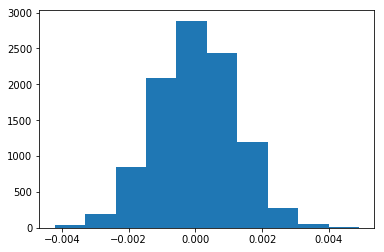

In [29]:
#plot histogeam of the p_diffs

plt.hist(p_diffs);

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [30]:
#calculate the observed differance in dataset between p_cont&p_treat were calculated before
obs_diff = p_treat - p_cont

#get the null values by normalizing the stander diviation of p_diffs
null_vals = np.random.normal(0, p_diffs.std(), p_diffs.size)

#the proportion of p_diffs greater than obs_diff to calculate the P-Value
(null_vals > obs_diff).mean()

0.90739999999999998

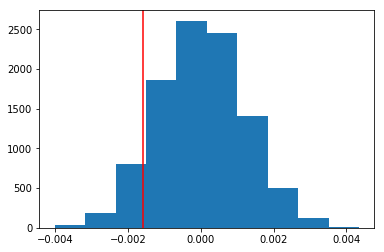

In [31]:
#plot the null distribution
plt.hist(null_vals)

#plot line for the observed differance
plt.axvline(obs_diff, color='red');

k. Please explain using the vocabulary you've learned in this course what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

- **From part j, we computed the P-Value.**
- **P-Value is the proportion of observing your data or more extreme data, if the null is true.**
- **Here, the P-Value is the probability of us observing the fact about individual's case that are in favor new_page, assuming that truly old_page**

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [32]:
import statsmodels.api as sm

convert_old = df2.query('landing_page == "old_page" and converted == 1').nunique()[0]
convert_new = df2.query('landing_page == "new_page" and converted == 1').nunique()[0]
n_old = df2.query('landing_page == "old_page"').nunique()[0]
n_new = df2.query('landing_page == "new_page"').nunique()[0]


/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](https://docs.w3cub.com/statsmodels/generated/statsmodels.stats.proportion.proportions_ztest/) is a helpful link on using the built in.

In [33]:
z_score, p_value = sm.stats.proportions_ztest([convert_old,convert_new], [n_old,n_new], alternative = 'larger')

print('P-Value:',1-p_value)

P-Value: 0.905058312759


n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

- **Fail to reject $H_{0}$ as P-Value = 0.9 which is greater than $\alpha$ = 0.05.**
- **And that agree with previous calculated in j part**

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**Logistic regression. As we predict a probability between 0 and 1.**

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives. However, you first need to create in df2 a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [34]:
#first we need to add intercept column
df2['intercept'] = 1

#Create dummy variables for pages and groups and add them to df2 dataframe
page_dummies = pd.get_dummies(df2.landing_page)
group_dummies = pd.get_dummies(df2.group)

df2 = df2.join(page_dummies).join(group_dummies)

#Rename treatment column as ab_page
df2.rename(columns={'treatment':'ab_page'}, inplace=True)

#drop unneeded column named "control"
df2 = df2.drop(['control'], axis=1)

#test our new dataframe
df2.head()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


user_id                   timestamp      group landing_page  converted  \
0   851104  2017-01-21 22:11:48.556739    control     old_page          0   
1   804228  2017-01-12 08:01:45.159739    control     old_page          0   
2   661590  2017-01-11 16:55:06.154213  treatment     new_page          0   
3   853541  2017-01-08 18:28:03.143765  treatment     new_page          0   
4   864975  2017-01-21 01:52:26.210827    control     old_page          1   

   intercept  new_page  old_page  ab_page  
0          1         0         1        0  
1          1         0         1        0  
2          1         1         0        1  
3          1         1         0        1  
4          1         0         1        0

c. Use **statsmodels** to instantiate your regression model on the two columns you created in part b., then fit the model using the two columns you created in part **b.** to predict whether or not an individual converts. 

In [35]:
#Create a logistic model to predict the individual convert
logit_mod = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])

#Fitting the model
results = logit_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [36]:
#Getting the summary
results.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2021-01-10 11:40 AIC:              212780.3502
No. Observations:   290584           BIC:              212801.5095
Df Model:           1                Log-Likelihood:   -1.0639e+05
Df Residuals:       290582           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0150    0.0114    -1.3109  0.1899  -0.0374   0.0074
==================================================================

"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in **Part II**?

- **P-Value for the ab_page 0.1899**
- **P-values for both parts are different because the null and alternative hypothesis here in regression if that population slope is equal to zero vs. an alternative where the parameter differs from zero. Thus, the one-tailed alternatives are that the coefficient is greater than zero and that the coefficient is less than zero.**
- **To get the p-value for the one-tailed test of the variable science having a coefficient greater than zero, you would divide the 0.1899 by 2, yielding 0.09495 because the effect is going in the predicted direction. the p-value would have been 1 – 0.09495 = 0.90505 which is the same as in Part II**
- **Here the P-Value is different than 0, so the ulternative is true**

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

- **Salary, Address, Age, Career and Gender are considered as other factors that may affect on the individual conversion.**
- **Adding additional terms makes the model more exposed to have multicollinearity between the variables**

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. You will need to read in the **countries.csv** dataset and merge together your datasets on the appropriate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [37]:
#read the new dataframe and name it dfc
dfc = pd.read_csv('countries.csv')

#explore dfc
dfc.head(1)

user_id country
0   834778      UK

In [38]:
#explore the values in country column to be used
dfc['country'].value_counts()

US    203619
UK     72466
CA     14499
Name: country, dtype: int64

In [39]:
#Merge our two dataframes df2 and dfc to the third new one called df_tot
df_tot = df2.join(dfc.set_index('user_id'), on='user_id')

In [40]:
#Create dummy variables from country column
df_tot[['US', 'UK', 'CA']] = pd.get_dummies(df_tot.country)

#Create a logistic model to predict the individual convert
logit_mod2 = sm.Logit(df_tot['converted'], df_tot[['intercept', 'US', 'UK']])

#Fitting the model
results2 = logit_mod2.fit()

#getting the summary
results2.summary2()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2021-01-10 11:40 AIC:              212780.8333
No. Observations:   290584           BIC:              212812.5723
Df Model:           2                Log-Likelihood:   -1.0639e+05
Df Residuals:       290581           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9967    0.0068  -292.3145  0.0000  -2.0101  -1.9833
US           -0.0408    0.0269    -1.5178  0.1291  -0.0935   0.0119
UK            0.0099    0.0133     0.7458  0.4558  -0.0161   0.0360
==================================================================

"""

- **As shown in the last summary, we can find that P-Values for UK and US are not equal to the P-Value for the intercept or the baseline, so the alternarive hypothesis is true.**
- **So, we have evidence that the country has a statistically significant linear relationship with the response.**

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [41]:
#Look at an interaction between page and country to see if there significant effects on conversion.
#by checking the variance inflation factor (vif)
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor

Y, X = dmatrices('converted ~ UK + US + ab_page', df_tot, return_type= 'dataframe' )

vif = pd.DataFrame()
vif['vif_Factor'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['Feature'] = X.columns

In [42]:
vif #Seemed like no correlation between the variables as VIF of all are less than 10

vif_Factor    Feature
0    2.428940  Intercept
1    1.017761         UK
2    1.017759         US
3    1.000006    ab_page

In [43]:
#Create new columns that combine the the page with countries
df_tot['ab_page_US'] = df_tot['ab_page'] * df_tot['US']
df_tot['ab_page_UK'] = df_tot['ab_page'] * df_tot['UK']

#Create a logistic final model to see if there significant effects on conversion
logit_mod3 = sm.Logit(df_tot['converted'], df_tot[['intercept', 'ab_page', 'US', 'UK','ab_page_US','ab_page_UK']])

#Fitting the final model
results3 = logit_mod3.fit()

#getting the summary
results3.summary2()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2021-01-10 11:40 AIC:              212782.6602
No. Observations:   290584           BIC:              212846.1381
Df Model:           5                Log-Likelihood:   -1.0639e+05
Df Residuals:       290578           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9865    0.0096  -206.3440  0.0000  -2.0053  -1.9676
ab_page      -0.0206    0.0137    -1.5052  0.1323  -0.0473   0.0062
US           -0.0175    0.0377    -0.4652  0.6418  -0.0914   0.0563
UK           -0.0057    0.0188    -0.3057  0.7598  -0.0426   0.0311
ab_page_US   -0.0469    0.0538    -0.8718  0.3833  -0.1523   0.0585
ab_page_UK    0.0314    0.0266     1.1807  0.2377  -0.0207   0.0835
==================================================================

"""


## Conclusion

> From the last analysis, we can find that we can predict the conversion by country and page as both of them statistically significant and no correlation between each of them.

> And because of the P-Value is greater than the threshold value so we fail to reject $H_{0}$, which mean that we shouldn't switch to the new page.

In [ ]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])